## Cloud Image Segmentation using a UNET model
Author : *Wassim Kabalan*<br>

## Imports

In [1]:
# @title
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

# Multiprocessing
import multiprocessing
from joblib import parallel_backend, Parallel, delayed
num_cores = multiprocessing.cpu_count()

import glob
from sklearn.model_selection import train_test_split
import os
import shutil
import random
from flax.training import orbax_utils
import orbax.checkpoint
import gc
import csv

In [2]:
# @title
!pip install -q optuna
import optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.6 MB/s eta 0:00:00


In [3]:
# @title
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
# @title
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../utilities')

import utilities as util
import augmentations as aug
import visualization as viz
from training_utilities import TrainingMetrics, TrainingTimer

# Model Creation and preprocessing

### Model creation using Blocks

In this code snippet, several classes representing different blocks of a U-Net architecture for semantic segmentation (named `CloudSegUNET`) are implemented using the Flax library, which is a high-performance neural network library designed for flexibility. The `jax` library is also utilized for efficient numerical computing.

1. **Importing Necessary Libraries**:
   - Importing essential libraries and modules such as `jax`, `flax`, `optax`, and `typing`.

2. **Double Convolution Block (`DoubleConvBlock`)**:
   - A block containing two sequential convolution layers followed by ReLU activations.
   - The convolution operations have a kernel size of 3x3 and use 'SAME' padding.

3. **Downsampling Block (`DownBlock`)**:
   - A block that applies a double convolution block and then performs max pooling with a window shape of 2x2 and a stride of 2 to downsample the feature map.

4. **Expansive Block (`ExpansiveBlock`)**:
   - A block that first upsamples the input feature map to match the dimensions of the skip connection using nearest neighbor interpolation.
   - It then concatenates the upsampled feature map with the skip connection feature map along the feature dimension.
   - Finally, it applies a double convolution block to the concatenated feature map.

5. **U-Net Architecture (`CloudSegUNET`)**:
   - The U-Net architecture starts with a series of downsampling blocks, each reducing the spatial dimensions of the input feature map while increasing the number of feature channels.
   - Skip connections from each downsampling block are saved for later use in the expansive blocks.
   - The architecture then transitions to a series of expansive blocks, each increasing the spatial dimensions of the feature map while decreasing the number of feature channels.
   - Each expansive block uses a skip connection from the corresponding downsampling block to provide high-resolution features.
   - Finally, a convolution layer with a single output channel is applied to generate the segmentation map.


In [5]:
import jax
from jax import jit, vmap, pmap, grad , numpy as jnp

from flax import linen as nn
from flax.training import train_state
import optax

from typing import Any, Callable, Sequence, Tuple, Dict

class DoubleConvBlock(nn.Module):
    input_channels: int = 128
    kernel_size: Tuple[int, int] = (3 ,3)

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=self.input_channels, kernel_size=self.kernel_size , padding='SAME')(x)
        x = nn.relu(x)
        x = nn.Conv(features=self.input_channels, kernel_size=self.kernel_size , padding='SAME')(x)
        x = nn.relu(x)
        return x

class DownBlock(nn.Module):
    input_channels: int = 128

    @nn.compact
    def __call__(self, x):
        conv = DoubleConvBlock(self.input_channels)(x)
        x = nn.max_pool(conv, window_shape=(2,2), strides=(2,2), padding='SAME')
        return x , conv

class ExpansiveBlock(nn.Module):
    input_channels: int = 128

    @nn.compact
    def __call__(self, x , skip_connection):
        x = jax.image.resize(image=x, shape=(x.shape[0] , skip_connection.shape[1] , skip_connection.shape[2] , x.shape[3] ), method="nearest")
        x = jnp.concatenate([x ,skip_connection],axis=-1)
        x = DoubleConvBlock(self.input_channels)(x)
        return x


class CloudSegUNET(nn.Module):
    input_channels: Sequence[int]
    bottle_neck_conv: int = 512
    output_channel: int=1
    @nn.compact
    def __call__(self, x):

        skip_outputs = []
        for conv_layer in self.input_channels:
            x , conv = DownBlock(conv_layer)(x)
            skip_outputs.append((conv_layer , conv))

        #x = nn.Conv(self.bottle_neck_conv, kernel_size=(3, 3))(x)
        #x = nn.relu(x)
        #x = jax.image.resize(x, (x.shape[0] * 2, x.shape[1] * 2, x.shape[2]) , method="nearest")

        for i , (unconv_layer , skip_output)  in enumerate(reversed(skip_outputs)):
            x = ExpansiveBlock(unconv_layer)(x,skip_output)

        x = nn.Conv(self.output_channel, kernel_size=(3, 3), padding='SAME')(x)
        return x

### Training functions

1. **Training State Class (`TrainState`)**:
   - A class inheriting from `train_state.TrainState` to represent the training state which includes a model configuration dictionary containing model parameters.

2. **Creating Training State (`create_train_state`)**:
   - Initializes the `CloudSegUNET` model with specified input channels and bottleneck convolution channels.
   - Initializes model parameters using a random number generator (`rng`) and an input shape.
   - Constructs an Adam optimizer with a cosine decay learning rate schedule.
   - Returns a `TrainState` object initialized with the model, parameters, optimizer, and model configuration.

3. **Loading Training State (`load_train_state`)**:
   - Similar to `create_train_state` but for loading a pre-existing training state from provided parameters and model configuration.

4. **Training Step (`train_step`)**:
   - A function decorated with `@jit` for Just-In-Time compilation to speed up execution.
   - Defines a nested `loss_fn` function to compute the loss and logits given model parameters.
   - Utilizes `jax.value_and_grad` to obtain both the loss and gradients in a single call.
   - Computes binary predictions, and accuracy.
   - Applies gradient updates to the model parameters.
   - Returns the updated training state, loss, and accuracy.

5. **Evaluation Step (`eval_step`)**:
   - A function decorated with `@jit` for Just-In-Time compilation, used to evaluate the model on validation data.
   - Computes the loss, binary predictions, and accuracy similar to `train_step`.
   - Returns the loss and accuracy.

6. **Prediction (`predict`)**:
   - A function decorated with `@jit` for Just-In-Time compilation, used to generate predictions on new data.
   - Computes the probability of the positive class using the sigmoid function.
   - Returns the probabilities.


In [6]:
class TrainState(train_state.TrainState):
    model_config: Dict  # This is the configuration or any other information about the model

def create_train_state(rng, input_shape, input_channels = [64 , 128, 256 , 512], bottle_neck_conv = 1024, learning_rate = 1e-3, total_steps = 10):
    model = CloudSegUNET(input_channels, bottle_neck_conv)
    params = model.init(rng, jnp.ones(input_shape, dtype=jnp.float32))['params']
    model_config = {"input_shape" : input_shape , "input_channels" : input_channels , "bottle_neck_conv" : bottle_neck_conv}
    # Initialize optimizer (Adam)
    cosine_decay_scheduler = optax.cosine_decay_schedule(learning_rate, decay_steps=total_steps, alpha=0.95)
    opt_adam = optax.adam(learning_rate=cosine_decay_scheduler)
    return TrainState.create(apply_fn=model.apply, params=params, tx=opt_adam,model_config=model_config)

def load_train_state(params, model_config, learning_rate = 1e-3, total_steps = 10):

    input_channels = model_config["input_channels"]
    bottle_neck_conv = model_config["bottle_neck_conv"]
    model = CloudSegUNET(input_channels,bottle_neck_conv)
    # Initialize optimizer (Adam)
    cosine_decay_scheduler = optax.cosine_decay_schedule(learning_rate, decay_steps=total_steps, alpha=0.95)
    opt_adam = optax.adam(learning_rate=cosine_decay_scheduler)
    return TrainState.create(apply_fn=model.apply, params=params, tx=opt_adam,model_config=model_config)

@jit
def train_step(state, images, labels):

    def loss_fn(params):
        logits = state.apply_fn({'params': params}, images)
        loss = jnp.mean(optax.sigmoid_binary_cross_entropy(logits=logits, labels=labels))
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)

    probs = jax.nn.sigmoid(logits)
    # Round to get binary predictions
    preds = jnp.round(probs)
    # Compute accuracy for binary classification
    accuracy = jnp.mean(preds == labels)
    new_state = state.apply_gradients(grads=grads)

    return new_state, loss, accuracy

@jit
def eval_step(state, images, labels):

    logits = state.apply_fn({'params': state.params}, images)
    loss = jnp.mean(optax.sigmoid_binary_cross_entropy(logits=logits, labels=labels))

    probs = jax.nn.sigmoid(logits)
    # Round to get binary predictions
    preds = jnp.round(probs)
    # Compute accuracy for binary classification
    accuracy = jnp.mean(preds == labels)

    return  loss, accuracy

@jit
def predict(state, images):
    logits = state.apply_fn({'params': state.params}, images)
    probs = jax.nn.sigmoid(logits)
    return probs

### Model persistency

1. **Saving Model (`save_model`)**:
   - Function to save the current training state of the Flax model using the orbax library.
   - Utilizes `orbax.checkpoint.PyTreeCheckpointer` to handle the saving of the model.
   - The `os.makedirs` function ensures the target directory exists, creating it if necessary.
   - The `save` method of `orbax_checkpointer` is called with the `force=True` argument to allow overwriting of an existing checkpoint.

2. **Loading Model (`load_model`)**:
   - Function to load a saved training state of the Flax model using the orbax library.
   - Utilizes `orbax.checkpoint.PyTreeCheckpointer` to handle the restoration of the model.
   - The `restore` method of `orbax_checkpointer` is called to load the training state from the specified model path.
   - Extracts model parameters and configuration from the restored training state.
   - Calls `load_train_state` with the restored parameters and configuration to recreate the training state, and returns this training state.


In [7]:
def save_model(state, model_path):
    """
    Save the Flax model using orbax.

    Parameters:
    - state: Flax train_state to be saved.
    - model_path: Path where the model will be saved.
    """
    orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
    save_args = orbax_utils.save_args_from_target({'model': state})
    target_dir = f"{model_path}/model"
    os.makedirs(target_dir, exist_ok=True)
    # The following line is new and allows overwriting of an existing checkpoint
    orbax_checkpointer.save(f"{model_path}/model", {'model': state}, save_args=save_args, force=True)

def load_model(model_path):
    """
    Load the Flax model using orbax.

    Parameters:
    - model_path: Path from where the model will be loaded.

    Returns:
    - state: Loaded Flax train_state.
    """
    orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
    restored_data = orbax_checkpointer.restore(model_path)
    state = restored_data['model']
    params = state['params']
    model_config = state['model_config']

    return load_train_state(params, model_config, learning_rate = 1e-3, total_steps = 10)

## Data Loading and Preprocessing

For this image segmentation task, our data consists of FITS (Flexible Image Transport System) files.

### Opening and Preprocessing FITS files

Our `open_fits_with_mask` function performs the following tasks:

**File Opening:** Opens the provided `FITS` file using the `fits.open()` method.\
**Extracting Image and Mask:** The function retrieves the actual image data (cloud) and the corresponding segmentation mask.
Normalization: To bring the pixel values within a standard range, the cloud data is normalized using a given DR value.

In [8]:
def open_fits_with_mask(filename,DR = 2**14):
    image = fits.open(filename)
    cloud = image[0].data

    mask = image[1].data
    del image

    # Normalize image
    cloud  = cloud / DR
    return cloud , mask

### Loading the Dataset

**Retrieve File Paths:** We obtain a list of all FITS files present in our specified directory.\
**Shuffle the List:** To ensure randomness and avoid any inherent order bias, we shuffle our list of images.\
**Parallel Processing:** Leveraging the joblib library, we employ parallel processing to efficiently load all our FITS files using multiple cores.

In [9]:
images_list = glob.glob('/gdrive/MyDrive/Colab/CIRRUS/CIRRUS_DS/public_datasets/HYTA/*.fits')
#images_list = glob.glob('/gdrive/MyDrive/Colab/CIRRUS/CIRRUS_DS/Segmentation/DS1_MASKED_SUBSET/*.fits')
images_list = random.choices(images_list, k=len(images_list))

with parallel_backend('threading', n_jobs=num_cores):
    l_fits = Parallel(verbose=0)(delayed(open_fits_with_mask)(filename=r,DR = 1) for r in images_list)
l_fits = np.array(l_fits)

In [10]:
len(images_list)

32

### Quick Visual Inspection

To verify our data loading process and get a sense of our data, we randomly select three images from our dataset.
Display them using the util.plot_image function.

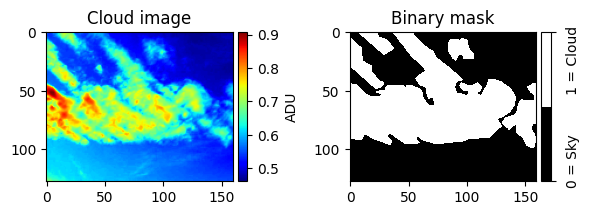

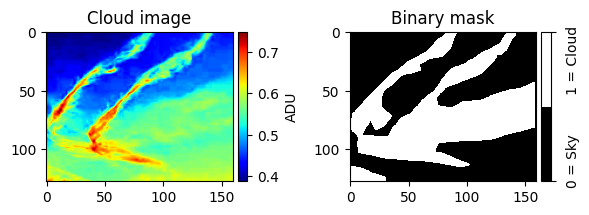

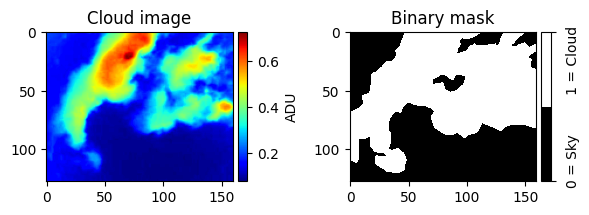

In [11]:
for _ in range(3):
    random_index = random.randint(0, len(l_fits) - 1)
    viz.plot_image(data=l_fits[random_index] , figsize=(6,3))

### Data set gen and batching

Training a neural network requires input data in batches. The custom data generator, CloudImageDataGenerator, ensures smooth data flow during training by dividing the dataset into batches and feeding it into the model. This is particularly important when the dataset is too large to fit into memory.

### Data Augmentation on the fly

the data set generator is used to train on batches of images\
Each set of batch is augmented by a parameter `aug_batch_size`

### Loading data in Jax Numpy Array

The only difference between this loader and the keras loader is the fact that we add a dimension (represting the grayscale channel) for convolutions and we return directly Jax numpy arrays


In [12]:
class CloudImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_data, y_data, batch_size=8,aug_batch_size=2, shuffle=True):
        self.x_data = x_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.aug_batch_size = aug_batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.x_data))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.x_data) / self.batch_size))

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        batch_indices = self.indices[start_idx:end_idx]

        batch_x = self.x_data[batch_indices]
        batch_y = self.y_data[batch_indices]

        # Create a list of tuples using zip
        batch_list = list(zip(batch_x, batch_y))

        if self.aug_batch_size != 0:
            l_fits_aug = [aug.random_augment(img_mask=random.choice(batch_list)) for _ in range(self.aug_batch_size)]
            fits_images_aug = np.array(l_fits_aug)

            batch_x =  np.concatenate((batch_x, fits_images_aug[:,0]), axis=0)
            batch_y =  np.concatenate((batch_y, fits_images_aug[:,1]), axis=0)

        # Convert the TensorFlow tensors to JAX arrays
        batch_x = jnp.array(batch_x[..., np.newaxis])
        batch_y = jnp.array(batch_y[..., np.newaxis])

        return batch_x, batch_y


    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

Split the data set into training and validation

In [13]:
indices = np.arange(len(l_fits))
np.random.shuffle(indices)

# Split the indices for train and test
train_idx = indices[:int(0.8 * len(indices))]
test_idx = indices[int(0.8 * len(indices)):]

# Use the indices to split the l_fits list
all_data = l_fits
train_data = l_fits[train_idx]
test_data = l_fits[test_idx]

# Separate images and masks
X_train, y_train = train_data[:,0], train_data[:,1]
X_test, y_test = test_data[:,0], test_data[:,1]
all_train, all_val= l_fits[:,0],l_fits[:,1]

Load the dataset generator\
We choose not to augment the validation set because it does not make sense

In [14]:
ds_train_gen = CloudImageDataGenerator(x_data=X_train,y_data=y_train,batch_size=64,aug_batch_size=16, shuffle=True)
ds_val_gen = CloudImageDataGenerator(x_data=X_test,y_data=y_test,batch_size=64,aug_batch_size=0, shuffle=False)

In [15]:
ds_gen = CloudImageDataGenerator(x_data=all_train,y_data=all_val,batch_size=32,aug_batch_size=0, shuffle=True)

# (Part 1) Training the base model

The following cell initializes the necessary variables and configurations for training a U-Net model. Random number generators are prepared, and the model's input shape, filter configurations, and training parameters like learning rate, number of epochs, and early stopping criteria are specified. A training state for the model is created using the `create_train_state` function. Additionally, the output path for saving the model and utility instances for tracking training metrics and time are


In [28]:
output_model_path = '/content/outputHYTA/HYTA_DS12_FromScratch'

In [29]:
# Initialize model
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
input_shape = (24, 160, 128, 1)
n_batches = len(ds_train_gen)

unet_filters = [128, 64,32, 16]
bottle_neck_conv = 1024
learning_rate  = 1e-3
state = create_train_state(init_rng, input_shape,unet_filters, bottle_neck_conv,learning_rate, n_batches)
num_epochs = 100

verbose = 2
patience = 10  # Number of epochs to wait before stopping
best_val_loss = float('inf')  # Store the best validation loss
counter = 0  # Keep track of how many epochs have passed since last best validation loss

metrics = TrainingMetrics()
timer = TrainingTimer()

The following cell outlines the main training loop for the model, iterating through each epoch and each batch of data in the training and validation datasets. In each epoch, the training metrics are reset, and the timer is started to keep track of the training time. The model parameters are updated in each training step using the `train_step` function, and training loss and accuracy are recorded. Similarly, validation loss and accuracy are computed using the `eval_step` function. Progress and average metrics are optionally printed to the console depending on the verbosity level.

If the average validation loss improves, the model checkpoint is saved, and the early stopping counter is reset. If the validation loss does not improve, the early stopping counter is incremented. If the counter reaches the specified patience, training is terminated early, and a message is printed to the console. This setup helps in both tracking the training progress and ensuring that training stops if there's no improvement, to save resources and time.


In [30]:
avg_train_loss = []
avg_val_loss = []
avg_train_accuracy = []
avg_val_accuracy = []

for epoch in range(num_epochs):
    metrics.reset()
    timer.start()

    for cnt, batch in enumerate(ds_train_gen):
        images, masks = batch
        state, loss, accuracy = train_step(state, images, masks)
        metrics.train_loss.append(loss)
        metrics.train_accuracy.append(accuracy)
        if verbose == 2 and cnt % ((n_batches // 10) + 1) == 0:
            avg_loss = metrics.avg_loss
            avg_accuracy = metrics.avg_accuracy
            print("\r", end="")
            print(f"Batch Number {cnt + 1}/{n_batches} - Loss: {avg_loss}, Accuracy: {avg_accuracy}", end="")

    for cnt, batch in enumerate(ds_val_gen):
        images, masks = batch
        loss, accuracy = eval_step(state, images, masks)
        metrics.test_loss.append(loss)
        metrics.test_accuracy.append(accuracy)

    epoch_time = timer.stop()
    if verbose >= 1:
        print("\r", end="")
        print(f"Epoch {epoch + 1}/{num_epochs} done - Loss: {metrics.avg_loss}, Accuracy: {metrics.avg_accuracy}, - val_Loss: {metrics.avg_val_loss}, val_Accuracy: {metrics.avg_val_acc},  Time taken: {epoch_time:.2f} seconds")
        avg_train_loss.append(metrics.avg_loss)
        avg_val_loss.append(metrics.avg_val_loss)
        avg_train_accuracy.append(metrics.avg_accuracy)
        avg_val_accuracy.append(metrics.avg_val_acc)

    if metrics.avg_val_loss < best_val_loss:
        best_val_loss = metrics.avg_val_loss
        counter = 0
        # Save the model checkpoint
        save_model(state, output_model_path)
    else:
        counter += 1
        if verbose >= 1:
            print(f"EarlyStopping counter: {counter} out of {patience}")
        if counter >= patience:
            if verbose >= 1:
                print("EarlyStopping: Stop training")
                break

Epoch 1/100 done - Loss: 0.6947565078735352, Accuracy: 0.37661728262901306, - val_Loss: 0.7578822374343872, val_Accuracy: 0.3330008387565613,  Time taken: 3.88 seconds
Epoch 2/100 done - Loss: 0.757270872592926, Accuracy: 0.3555711805820465, - val_Loss: 0.7012922167778015, val_Accuracy: 0.4423409700393677,  Time taken: 0.16 seconds
Epoch 3/100 done - Loss: 0.6881934404373169, Accuracy: 0.38991042971611023, - val_Loss: 0.7655296325683594, val_Accuracy: 0.4423409700393677,  Time taken: 0.16 seconds
EarlyStopping counter: 1 out of 10
Epoch 4/100 done - Loss: 0.7274576425552368, Accuracy: 0.3608231842517853, - val_Loss: 0.7142292857170105, val_Accuracy: 0.4423409700393677,  Time taken: 0.14 seconds
EarlyStopping counter: 2 out of 10
Epoch 5/100 done - Loss: 0.7101117968559265, Accuracy: 0.3446122407913208, - val_Loss: 0.6961250901222229, val_Accuracy: 0.4423409700393677,  Time taken: 0.16 seconds
Epoch 6/100 done - Loss: 0.6946113109588623, Accuracy: 0.3712950050830841, - val_Loss: 0.69136

## Evaluate the base model

In [31]:
from tqdm import tqdm  # Import tqdm

def save_image(entry, output_prefix, counter):
    image, mask, pred = entry

    target_file = f"{output_model_path}/Results/{output_prefix}_{counter:04d}"
    viz.save_image_pred(
        cloud_image=image,
        binary_mask=mask,
        y_pred=pred,
        output_path=target_file,
        figsize=(8,4),
        predmask_cmap='jet'
    )

def evaluate_and_save_images(data_gen, state, output_prefix,evaluate=False,images_to_save=0):
    all_images = []
    all_predictions = []
    all_groundtruth = []

    # Predictions
    for batch in data_gen:
        images, masks = batch

        batch_predictions = predict(state, images)
        all_images.append(images)
        all_predictions.append(batch_predictions)
        all_groundtruth.append(masks)

    # Concatenate and squeeze
    all_images = jnp.concatenate(all_images, axis=0); x_img = all_images.squeeze(axis=-1)
    all_predictions = jnp.concatenate(all_predictions, axis=0); y_pred = all_predictions.squeeze(axis=-1)
    all_groundtruth = jnp.concatenate(all_groundtruth, axis=0); y_test = all_groundtruth.squeeze(axis=-1)

    # Evaluate
    if evaluate:
        os.makedirs(f"{output_model_path}", exist_ok=True)
        util.evaluate_model(y_test, y_pred, output_file=f"{output_model_path}/evaluation_results.md", plot_file=f"{output_model_path}/roc_plot.png")

    # Save images, predictions and ground truth
    if images_to_save != 0:
        os.makedirs(f"{output_model_path}/Results", exist_ok=True)
        entries = zip(all_images, all_groundtruth, all_predictions)
        for counter, entry in tqdm(enumerate(entries, start=1), total=images_to_save):
            save_image(entry, output_prefix, counter)
            if counter >= images_to_save:
                break

        #with parallel_backend('threading', n_jobs=num_cores):
        #    Parallel(verbose=0)(delayed(save_image)(entry, output_prefix, counter) for counter, entry in enumerate(entries, start=1))

    return x_img ,y_test ,y_pred

Mean Accuracy: 0.5599
Mean Precision: 1.0000
Mean Recall: 0.0012
Mean F1 Score: 0.0025
Error Rate (ER): 0.4401
BinaryCrossEntropy Loss: 0.6376
IOU: 0.0012
Mean AUC: 0.5006



 41%|████      | 41/100 [00:20<00:29,  2.03it/s]


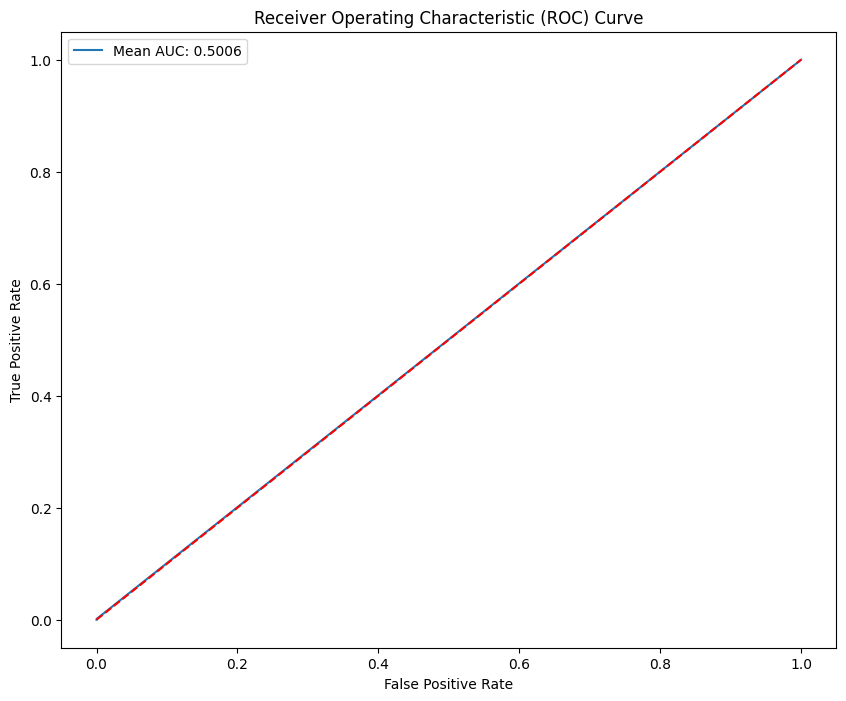

In [32]:
# Evaluate the model on validation and training sets
images, masks , pred = evaluate_and_save_images(ds_val_gen, state, "DS12Model_HYTA_FromScratchVal",True,200)
images_t, masks_t , pred_t = evaluate_and_save_images(ds_train_gen, state, "DS12Model_HYTA_FromScratchTrain",False,100)

In [33]:
def save_metrics_to_csv(avg_train_loss, avg_val_loss, avg_train_accuracy, avg_val_accuracy, file_path='metrics.csv'):
    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Avg_Train_Loss', 'Avg_Val_Loss', 'Avg_Train_Accuracy', 'Avg_Val_Accuracy'])
        for epoch, (train_loss, val_loss, train_acc, val_acc) in enumerate(zip(avg_train_loss, avg_val_loss, avg_train_accuracy, avg_val_accuracy), start=1):
            writer.writerow([epoch, train_loss, val_loss, train_acc, val_acc])

# Call the function to save the metrics to a CSV file
save_metrics_to_csv(avg_train_loss, avg_val_loss, avg_train_accuracy, avg_val_accuracy, file_path=f'{output_model_path}/metrics.csv')

## Plot some results

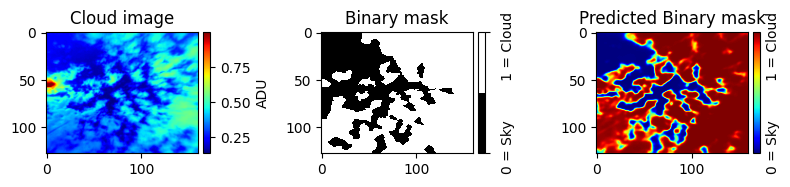

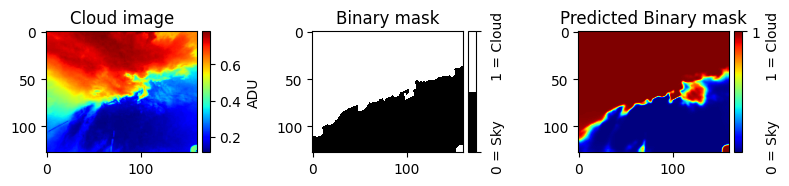

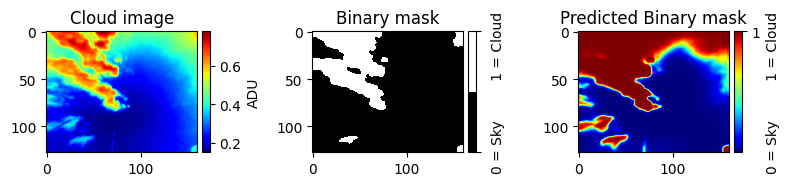

In [79]:
for _ in range(3):
    random_index = random.randint(0, len(images) - 1)
    viz.plot_image_pred(images[random_index], masks[random_index], pred[random_index], figsize=(8,4),predmask_cmap='jet')

# (Part 2) Hyperparameter optimizing using Optuna

The following cell defines an objective function for an Optuna optimization trial to find the best set of filters for a U-Net model. Here's a brief breakdown:

1. **Hyperparameter Suggestion**:
   - Optuna's `trial.suggest_categorical` method is used to suggest a string representing a set of U-Net filters from a predefined list of options.

2. **Model Initialization**:
   - The U-Net model is initialized with the suggested filters using the `create_train_state` function.

3. **Training Loop**:
   - A training loop is implemented, going through a specified number of epochs, processing batches from the training data generator, and evaluating on the validation data generator.

4. **Intermediate Reporting**:
   - The average validation loss is reported to Optuna at the end of each epoch using `trial.report`. This allows Optuna to track the progress of the trial.

5. **Pruning Check**:
   - `trial.should_prune` is called to check if the trial should be pruned based on its performance so far. If it should be pruned, an exception is raised to stop the trial early.

6. **Early Stopping and Model Saving**:
   - Implements an early stopping mechanism based on validation loss, and saves the model checkpoint whenever a new best validation loss is observed.


In [ ]:
def objective(trial):
    # Suggest a set of channels

    try:
        unet_filters_str = trial.suggest_categorical(
            'unet_filters', [
                '64_128_256', '256_128_64',
                '32_64_128', '128_64_32',
                '128_256_512', '512_256_128',
                '32_64_128_256', '256_128_64_32',
                '16_32_64_128', '128_64_32_16',
                '8_16_32_64', '64_32_16_8',
                '16_32_64', '64_32_16',
                '8_16_32', '32_16_8',
                '4_8_16_32', '32_16_8_4'
            ]
        )


        print(unet_filters_str)
        # Convert the string back to a list of ints
        unet_filters = [int(x) for x in unet_filters_str.split('_')]

        # Initialize model
        rng = jax.random.PRNGKey(0)
        rng, init_rng = jax.random.split(rng)
        input_shape = (24, 160, 128, 1)
        n_batches = len(ds_train_gen)

        bottle_neck_conv = 1024
        learning_rate  = 1e-3
        state = create_train_state(init_rng, input_shape, unet_filters, bottle_neck_conv, learning_rate, n_batches)
        num_epochs = 50

        verbose = 2
        patience = 10  # Number of epochs to wait before stopping
        best_val_loss = float('inf')  # Store the best validation loss
        counter = 0  # Keep track of how many epochs have passed since last best validation loss
        output_model_path = '/output'

        metrics = TrainingMetrics()
        timer = TrainingTimer()

        for epoch in range(num_epochs):
            metrics.reset()
            timer.start()

            for cnt, batch in enumerate(ds_train_gen):
                images, masks = batch
                state, loss, accuracy = train_step(state, images, masks)
                metrics.train_loss.append(loss)
                metrics.train_accuracy.append(accuracy)
                if verbose == 2 and cnt % (n_batches // 10) == 0:
                    avg_loss = metrics.avg_loss
                    avg_accuracy = metrics.avg_accuracy
                    print("\r", end="")
                    print(f"Batch Number {cnt + 1}/{n_batches} - Loss: {avg_loss}, Accuracy: {avg_accuracy}", end="")

            for cnt, batch in enumerate(ds_val_gen):
                images, masks = batch
                loss, accuracy = eval_step(state, images, masks)
                metrics.test_loss.append(loss)
                metrics.test_accuracy.append(accuracy)

            epoch_time = timer.stop()
            if verbose >= 1:
                print("\r", end="")
                print(f"Epoch {epoch + 1}/{num_epochs} done - Loss: {metrics.avg_loss}, Accuracy: {metrics.avg_accuracy}, - val_Loss: {metrics.avg_val_loss}, val_Accuracy: {metrics.avg_val_acc},  Time taken: {epoch_time:.2f} seconds")

            # Report intermediate results to Optuna
            trial.report(metrics.avg_val_loss, epoch)

            # Check if the current trial should be pruned
            if trial.should_prune():
                raise optuna.TrialPruned()

            if metrics.avg_val_loss < best_val_loss:
                best_val_loss = metrics.avg_val_loss
                counter = 0
                # Save the model checkpoint
                save_model(state, f"{output_model_path}/{unet_filters_str}")
            else:
                counter += 1
                if verbose >= 1:
                    print(f"EarlyStopping counter: {counter} out of {patience}")
                if counter >= patience:
                    if verbose >= 1:
                        print("EarlyStopping: Stop training")
                    break
    finally:
        # Memory cleanup
        if state is not None:
            jax.tree_util.tree_map(lambda x: x.device_buffer.delete(), state)
            del state
            gc.collect()

    return best_val_loss


In [ ]:
pruner = optuna.pruners.MedianPruner()
study = optuna.create_study(direction='minimize', pruner=pruner)
study.optimize(objective, n_trials=10)  # specify the number of trials

# Results
print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2023-10-13 08:44:40,360] A new study created in memory with name: no-name-a4dfb9dc-a0a8-45ba-9491-8b4bd4840a6f


64_128_256
Epoch 1/50 done - Loss: 0.7052245736122131, Accuracy: 0.508211612701416, - val_Loss: 0.6913230419158936, val_Accuracy: 0.508909285068512,  Time taken: 72.96 seconds
Epoch 2/50 done - Loss: 0.6883302927017212, Accuracy: 0.5039623379707336, - val_Loss: 0.6891956329345703, val_Accuracy: 0.508909285068512,  Time taken: 2.81 seconds
Epoch 3/50 done - Loss: 0.6890442967414856, Accuracy: 0.49677836894989014, - val_Loss: 0.6890145540237427, val_Accuracy: 0.508909285068512,  Time taken: 2.79 seconds
Epoch 4/50 done - Loss: 0.6878666281700134, Accuracy: 0.5027271509170532, - val_Loss: 0.6893022060394287, val_Accuracy: 0.508909285068512,  Time taken: 2.83 seconds
EarlyStopping counter: 1 out of 10
Epoch 5/50 done - Loss: 0.6869983673095703, Accuracy: 0.5069110989570618, - val_Loss: 0.6892135143280029, val_Accuracy: 0.508909285068512,  Time taken: 2.83 seconds
EarlyStopping counter: 2 out of 10
Epoch 6/50 done - Loss: 0.6875166296958923, Accuracy: 0.5040127635002136, - val_Loss: 0.68905

[I 2023-10-13 08:46:50,265] Trial 0 finished with value: 0.6889312267303467 and parameters: {'unet_filters': '64_128_256'}. Best is trial 0 with value: 0.6889312267303467.


128_64_32_16
Epoch 1/50 done - Loss: 0.6909363269805908, Accuracy: 0.4886343479156494, - val_Loss: 0.6895486116409302, val_Accuracy: 0.508909285068512,  Time taken: 8.82 seconds
Epoch 2/50 done - Loss: 0.6883123517036438, Accuracy: 0.5020790100097656, - val_Loss: 0.6889876127243042, val_Accuracy: 0.508909285068512,  Time taken: 2.78 seconds
Epoch 3/50 done - Loss: 0.6879878044128418, Accuracy: 0.5035701990127563, - val_Loss: 0.6889181137084961, val_Accuracy: 0.508909285068512,  Time taken: 2.85 seconds
Epoch 4/50 done - Loss: 0.6870900392532349, Accuracy: 0.5073997378349304, - val_Loss: 0.6896567344665527, val_Accuracy: 0.508909285068512,  Time taken: 2.74 seconds
EarlyStopping counter: 1 out of 10
Epoch 5/50 done - Loss: 0.6873472929000854, Accuracy: 0.5050246119499207, - val_Loss: 0.6888783574104309, val_Accuracy: 0.508909285068512,  Time taken: 2.77 seconds
Epoch 6/50 done - Loss: 0.6873688697814941, Accuracy: 0.5059393644332886, - val_Loss: 0.6889919638633728, val_Accuracy: 0.50890

[I 2023-10-13 08:49:19,254] Trial 1 finished with value: 0.6819483041763306 and parameters: {'unet_filters': '128_64_32_16'}. Best is trial 1 with value: 0.6819483041763306.


256_128_64
Epoch 1/50 done - Loss: 0.6978590488433838, Accuracy: 0.49509555101394653, - val_Loss: 0.691473126411438, val_Accuracy: 0.508909285068512,  Time taken: 206.78 seconds
Epoch 2/50 done - Loss: 0.6882438659667969, Accuracy: 0.504916787147522, - val_Loss: 0.6913638114929199, val_Accuracy: 0.508909285068512,  Time taken: 5.03 seconds
Epoch 3/50 done - Loss: 0.6897631883621216, Accuracy: 0.49952811002731323, - val_Loss: 0.6893097162246704, val_Accuracy: 0.508909285068512,  Time taken: 5.05 seconds
Epoch 4/50 done - Loss: 0.6863529086112976, Accuracy: 0.5089740753173828, - val_Loss: 0.6899098753929138, val_Accuracy: 0.508909285068512,  Time taken: 5.10 seconds
EarlyStopping counter: 1 out of 10
Epoch 5/50 done - Loss: 0.6894320845603943, Accuracy: 0.49936744570732117, - val_Loss: 0.6890419125556946, val_Accuracy: 0.508909285068512,  Time taken: 5.06 seconds
Epoch 6/50 done - Loss: 0.6880272030830383, Accuracy: 0.5026251673698425, - val_Loss: 0.6889861226081848, val_Accuracy: 0.5089

[I 2023-10-13 08:57:21,773] Trial 2 finished with value: 0.6887825131416321 and parameters: {'unet_filters': '256_128_64'}. Best is trial 1 with value: 0.6819483041763306.


256_128_64_32
Epoch 1/50 done - Loss: 0.7239916920661926, Accuracy: 0.5078474283218384, - val_Loss: 0.6923819780349731, val_Accuracy: 0.508909285068512,  Time taken: 15.19 seconds
Epoch 2/50 done - Loss: 0.6887628436088562, Accuracy: 0.5082637667655945, - val_Loss: 0.6909324526786804, val_Accuracy: 0.508909285068512,  Time taken: 5.05 seconds
Epoch 3/50 done - Loss: 0.6879447102546692, Accuracy: 0.507091224193573, - val_Loss: 0.6889721155166626, val_Accuracy: 0.508909285068512,  Time taken: 5.14 seconds
Epoch 4/50 done - Loss: 0.6870682835578918, Accuracy: 0.5058112144470215, - val_Loss: 0.6892188787460327, val_Accuracy: 0.508909285068512,  Time taken: 5.07 seconds
EarlyStopping counter: 1 out of 10
Epoch 5/50 done - Loss: 0.6878927946090698, Accuracy: 0.5016365051269531, - val_Loss: 0.688909649848938, val_Accuracy: 0.508909285068512,  Time taken: 5.12 seconds
Epoch 6/50 done - Loss: 0.6877711415290833, Accuracy: 0.5032373070716858, - val_Loss: 0.6890532970428467, val_Accuracy: 0.50890

[W 2023-10-13 09:01:03,837] Trial 3 failed with parameters: {'unet_filters': '256_128_64_32'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-23-9d7841ece13f>", line 48, in objective
    for cnt, batch in enumerate(ds_train_gen):
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/data_utils.py", line 567, in __iter__
    for item in (self[i] for i in range(len(self))):
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/data_utils.py", line 567, in <genexpr>
    for item in (self[i] for i in range(len(self))):
  File "<ipython-input-11-64c9c2c23522>", line 27, in __getitem__
    l_fits_aug = [aug.random_augment(img_mask=random.choice(batch_list)) for _ in range(self.aug_batch_size)]
  File "<ipython-input-11-64c9c2c23522>", line 27, in <listcomp>
    l_fits_aug = [aug

KeyboardInterrupt: ignored

# (Part 3) Load existing model

The following cell performs two main tasks:

1. **Model Loading**:
   - Utilizes the `load_model` function to load a pre-trained model from the specified path, and stores the loaded state in `loaded_state`.

2. **Model Evaluation and Image Saving**:
   - Calls the `evaluate_and_save_images` function with the validation data generator (`ds_val_gen`), the loaded model state, and a specified output prefix. It also sets flags for evaluating the model and saving images to `True`. This function will evaluate the model on the validation set, save images along with their predictions and ground truth to the specified path, and return the images, masks, and predictions which are stored in `images`, `masks`, and `pred` respectively.


In [17]:
state = load_model('/gdrive/MyDrive/Colab/CIRRUS/CIRRUS_DS/Models/DS2_MASKED_SUBSET_SEG/model')

In [ ]:
# Evaluate the model on validation and training sets
images, masks , pred = evaluate_and_save_images(ds_val_gen, state, "SWINSEG_DS12_FromScratch_Val",True,200)
images_t, masks_t , pred_t = evaluate_and_save_images(ds_train_gen, state, "SWINSEG_DS12_FromScratch_Train",False,100)

Mean Accuracy: 0.4585
Mean Precision: 0.4317
Mean Recall: 0.9607
Mean F1 Score: 0.5957
Error Rate (ER): 0.5415
BinaryCrossEntropy Loss: 8.1540
IOU: 0.4242
Mean AUC: 0.5313



 64%|██████▍   | 32/50 [00:15<00:08,  2.01it/s]


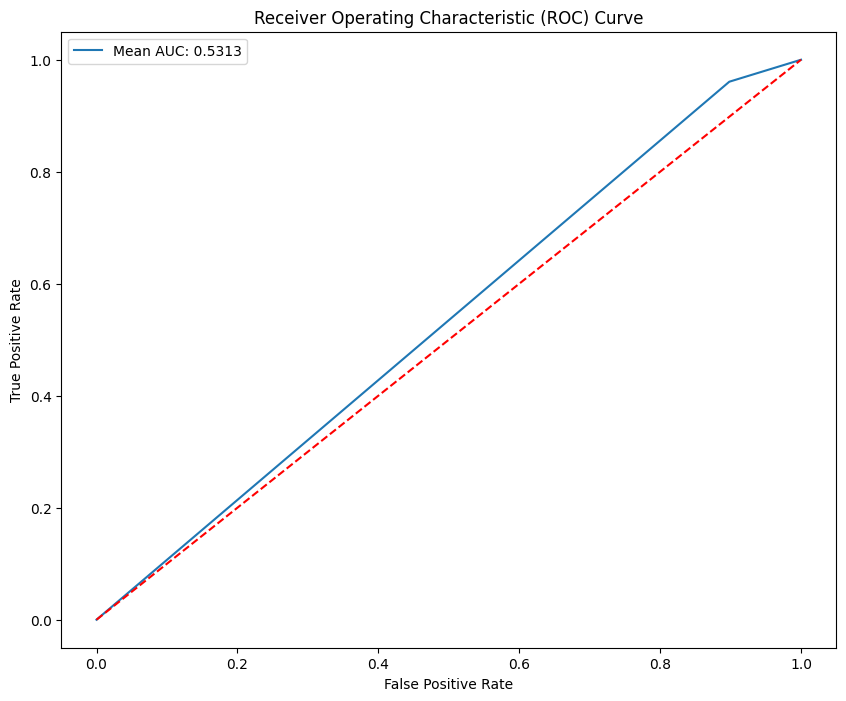

In [21]:
# Evaluate the model on validation and training sets
images, masks , pred = evaluate_and_save_images(ds_gen, state, "DS12Model_HYTA",True,50)

# Download results

In [35]:
import os
from google.colab import files
import shutil

def zip_and_download(folder_name, zip_name=None,to_drive=False):
    """
    Zips the specified folder and initiates a download of the zipped file.

    Parameters:
    - folder_name (str): Name of the folder to be zipped.
    - zip_name (str, optional): Name of the resulting zip file. If None, same name as folder is used.
    """
    if zip_name is None:
        zip_name = folder_name

    # Ensure the provided folder exists
    if not os.path.exists(folder_name):
        print(f"No such folder: '{folder_name}'")
        return

    # Zip the folder
    shutil.make_archive(zip_name, 'zip', folder_name)

    if to_drive:
        shutil.copy(f"/content/{zip_name}.zip", f"/gdrive/MyDrive/Colab/CIRRUS/{zip_name}.zip")
    else:
        # Initiate download
        try:
            files.download(zip_name + '.zip')
        except Exception as e:
            print(f"Error: {str(e)}")


In [ ]:
zip_and_download('/content/outputHYTA','outputHYTA',True)